In [ ]:
# Connect to Google Drive - remember to make a shortcut of the "Patches" folder to "My Drive"
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Import necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import OrderedDict
from datetime import datetime
from PIL import Image
import seaborn as sns
import shutil
import re
from torchvision.utils import save_image
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

Mounted at /content/drive


Clipped 739 images to 1000000 bytes for visualization.


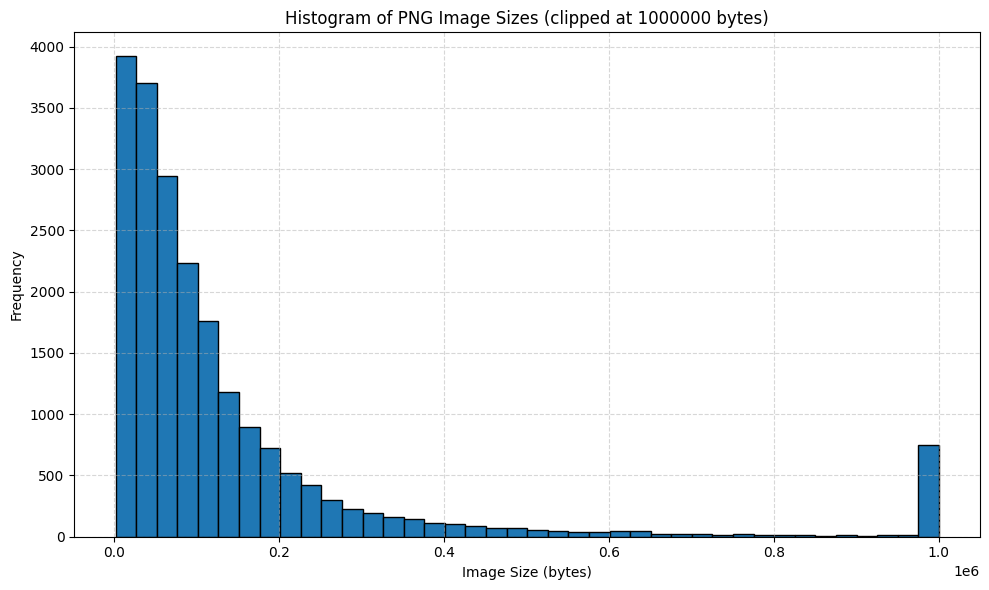

In [ ]:

def plot_image_size_histogram(
    folder_path,
    bins=60,
    log_scale=False,
    clip_at=None
):
    """
    Scans PNG images in a folder and plots a histogram of their file sizes in bytes,
    optionally clipping all sizes above `clip_at` to that value.

    Parameters:
      folder_path (str): Path to folder with PNG images.
      bins (int): Number of histogram bins.
      log_scale (bool): If True, use log scale on the x-axis.
      clip_at (int or None): If set, all sizes > clip_at are replaced by clip_at.
    """
    sizes = []
    with os.scandir(folder_path) as entries:
        for entry in entries:
            if entry.is_file() and entry.name.lower().endswith('.png'):
                sizes.append(entry.stat().st_size)

    if not sizes:
        print("No PNG images found in the folder.")
        return

    # Apply clipping if requested
    if clip_at is not None:
        clipped_count = sum(1 for s in sizes if s > clip_at)
        sizes = [min(s, clip_at) for s in sizes]
        print(f"Clipped {clipped_count} images to {clip_at} bytes for visualization.")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(sizes, bins=bins, edgecolor='black')
    plt.xlabel("Image Size (bytes)" if not log_scale else "Image Size (log bytes)")
    plt.ylabel("Frequency")
    title = "Histogram of PNG Image Sizes"
    if clip_at is not None:
        title += f" (clipped at {clip_at} bytes)"
    plt.title(title)

    if log_scale:
        plt.xscale("log")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Example usage:
folder = "/content/drive/MyDrive/filtered_patches_SP2025_h&e_Apr27"
# Clip any image > 20000 bytes down to 20000 for the histogram:
plot_image_size_histogram(folder, bins=40, log_scale=False, clip_at=1000000)

In [ ]:
# import os
# import shutil
# from PIL import Image
# import numpy as np

# def filter_images_by_size_percentile(
#     input_folder: str,
#     output_folder: str,
#     lower_percentile: float = 10,
#     upper_percentile: float = 90
# ):
#     """
#     Filters images in input_folder based on pixel size percentiles and saves them to output_folder.

#     Parameters:
#     - input_folder (str): Path to the source image folder.
#     - output_folder (str): Path to save filtered images.
#     - lower_percentile (float): Lower size percentile cutoff (e.g., 10).
#     - upper_percentile (float): Upper size percentile cutoff (e.g., 90).
#     """
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)

#     image_files = [
#         f for f in os.listdir(input_folder)
#         if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".bmp"))
#     ]

#     image_sizes = []
#     size_map = {}

#     for fname in image_files:
#         fpath = os.path.join(input_folder, fname)
#         try:
#             with Image.open(fpath) as img:
#                 width, height = img.size
#                 size = width * height
#                 image_sizes.append(size)
#                 size_map[fname] = size
#         except Exception as e:
#             print(f"Error reading {fname}: {e}")

#     if not image_sizes:
#         print("No valid images found.")
#         return

#     # Compute thresholds
#     lower = np.percentile(image_sizes, lower_percentile)
#     upper = np.percentile(image_sizes, upper_percentile)

#     print(f"Keeping images with sizes between {int(lower)} and {int(upper)} pixels.")

#     # Filter and copy
#     for fname, size in size_map.items():
#         if lower <= size <= upper:
#             shutil.copy(os.path.join(input_folder, fname), os.path.join(output_folder, fname))

#     print(f"Filtered images saved to: {output_folder}")

In [ ]:
# filter_images_by_size_percentile(
#     input_folder="/content/drive/MyDrive/filtered_patches_SP2025_h&e_Apr27",
#     output_folder="/content/drive/MyDrive/filtered_patches_SP2025_h&e_Apr27_middle60",
#     lower_percentile=20,
#     upper_percentile=80
# )

Clipped 0 images to 1000000 bytes for visualization.


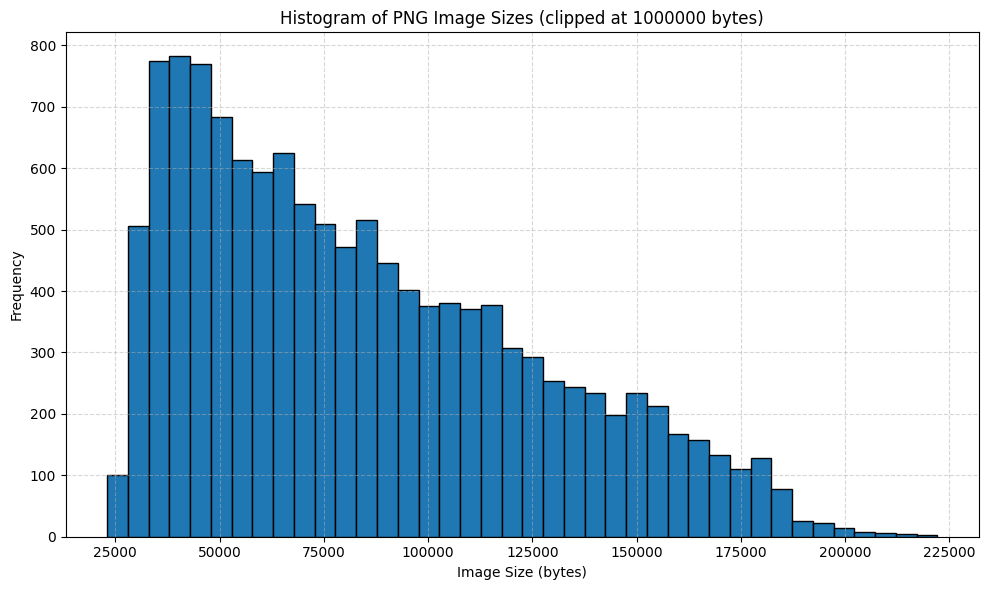

In [ ]:
# Example usage:
folder = '/content/drive/MyDrive/filtered_patches_SP2025_h&e_Apr27_middle60'
# Clip any image > 20000 bytes down to 20000 for the histogram:
plot_image_size_histogram(folder, bins=40, log_scale=False, clip_at=1000000)

Clipped 45 images to 1000000 bytes for visualization.


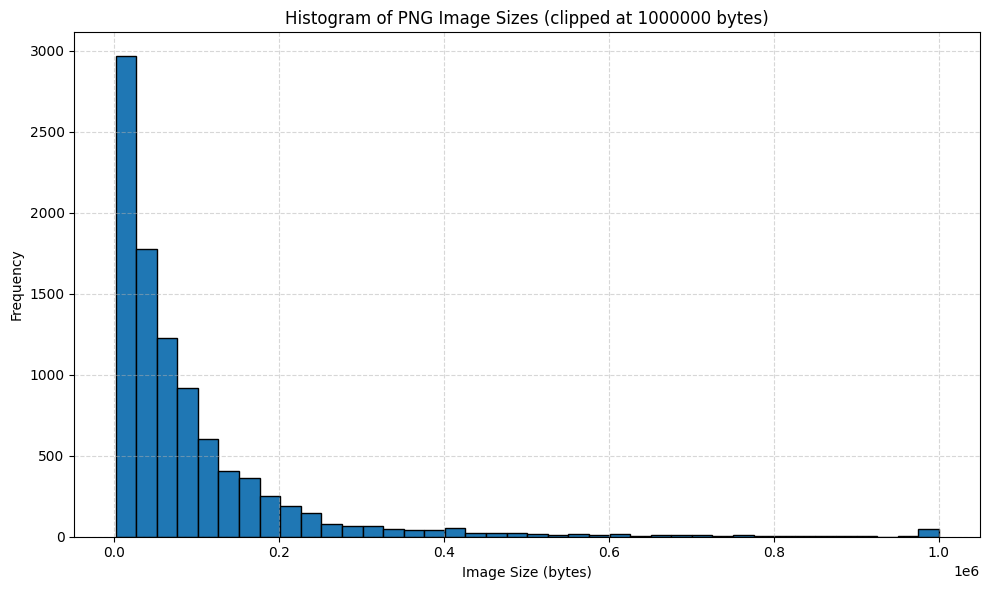

In [ ]:
# Example usage:
folder = '/content/drive/MyDrive/filtered_patches_SP2025_h&e'
# Clip any image > 20000 bytes down to 20000 for the histogram:
plot_image_size_histogram(folder, bins=40, log_scale=False, clip_at=1000000)


📊 TRAIN SET SUMMARY:
Total cases: 28
  Case 79: 377 patches (Label: Benign)
  Case 11: 88 patches (Label: High-grade)
  Case 30: 131 patches (Label: Benign)
  Case 48: 258 patches (Label: High-grade)
  Case 82: 215 patches (Label: Benign)
  Case 2: 106 patches (Label: Benign)
  Case 89: 154 patches (Label: High-grade)
  Case 94: 177 patches (Label: Benign)
  Case 9: 54 patches (Label: High-grade)
  Case 78: 128 patches (Label: Benign)
  Case 68: 124 patches (Label: High-grade)
  Case 96: 223 patches (Label: Benign)
  Case 99: 53 patches (Label: High-grade)
  Case 1: 49 patches (Label: High-grade)
  Case 15: 509 patches (Label: High-grade)
  Case 12: 60 patches (Label: High-grade)
  Case 100: 125 patches (Label: High-grade)
  Case 5: 125 patches (Label: High-grade)
  Case 3: 101 patches (Label: High-grade)
  Case 83: 385 patches (Label: High-grade)
  Case 4: 113 patches (Label: Benign)
  Case 66: 235 patches (Label: High-grade)
  Case 42: 110 patches (Label: High-grade)
  Case 97: 487 

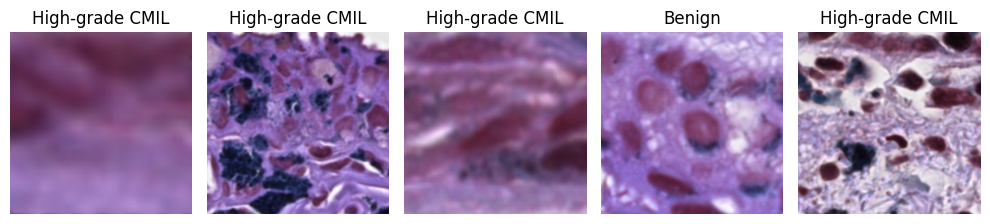

✅ Saved image paths and labels:
{'path': '/content/drive/My Drive/attention_patches_melan/patch_0_label_1.png', 'label': 1}
{'path': '/content/drive/My Drive/attention_patches_melan/patch_1_label_1.png', 'label': 1}
{'path': '/content/drive/My Drive/attention_patches_melan/patch_2_label_1.png', 'label': 1}
{'path': '/content/drive/My Drive/attention_patches_melan/patch_3_label_0.png', 'label': 0}
{'path': '/content/drive/My Drive/attention_patches_melan/patch_4_label_1.png', 'label': 1}


In [ ]:
# Add labels to each patch and match by their case, randomly split patients into training, validation, and testing sets

labels = pd.read_csv('/content/drive/My Drive/case_grade_match.csv') # Replace with the path to file

# Define a function to group patches by case number
def group_patches(patch_dir):
    case_patches = {}
    for filename in os.listdir(patch_dir):
        match = re.search(r"case_(\d+)", filename)  # Using regex for case number extraction
        if match:
            case_num = int(match.group(1))
            if case_num not in case_patches:
                case_patches[case_num] = []
            case_patches[case_num].append(os.path.join(patch_dir, filename))
    return case_patches

# Define a custom dataset class for loading PNG images
class PNGDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None):
        self.case_patches = case_patches
        self.labels_df = labels_df
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Label benign images 0, and high-grade CMIL images 1
        for case_num, patches in case_patches.items():
            label = labels_df.loc[labels_df['Case'] == case_num, 'Class'].values[0]
            label = 0 if label == 1 else 1
            for patch_path in patches:
                self.image_paths.append(patch_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        # Get patch images
        image = Image.open(image_path).convert('RGB')
        # Get the label information using the labels dataframe based on case number
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

# Resize all patch images to 256x256
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Possible data augmentation for training data
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

image_folder_path = '/content/drive/MyDrive/filtered_patches_SP2025_h&e' # Replace with the path to filtered patches
patches = group_patches(image_folder_path)

# Get case numbers and their labels
case_nums = list(patches.keys())
dataset = labels.loc[[(int(x)-1) for x in case_nums]]

# Remove those that are equal to 2 (not classifying low-grade CMIL images currently)
noindex = ~dataset.Class.isin([0.0, 2.0])
X = dataset[noindex].Case
y = dataset[noindex].Class

# Ensure X and y have the same length before splitting
X = X.reset_index(drop=True)  # Reset index to avoid potential issues
y = y.reset_index(drop=True)  # Reset index to avoid potential issues

# Split the data into train, test, and validation sets
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)
train_X, val_X, y_train, y_val = train_test_split(train_X, y_train, test_size=0.2, stratify=y_train, random_state=40)

# Create the training, validation, and testing patches
train_patches = {case_num: patches[int(case_num)] for case_num in train_X} # Use train_X
val_patches = {case_num: patches[int(case_num)] for case_num in val_X} # Use val_X
test_patches = {case_num: patches[int(case_num)] for case_num in test_X} # Use test_X

def summarize_case_patches(split_name, split_dict, labels_df):
    print(f"\n📊 {split_name.upper()} SET SUMMARY:")
    print(f"Total cases: {len(split_dict)}")
    total_patches = benign_patches = high_grade_patches = unknown_cases = 0

    for case_num, patch_list in split_dict.items():
        num_patches = len(patch_list)
        total_patches += num_patches
        label_row = labels_df[labels_df['Case'] == int(case_num)]
        if label_row.empty:
            unknown_cases += 1
            continue
        original_label = label_row['Class'].values[0]
        label = 0 if original_label == 1 else 1
        if label == 0:
            benign_patches += num_patches
        else:
            high_grade_patches += num_patches
        print(f"  Case {case_num}: {num_patches} patches (Label: {'Benign' if label == 0 else 'High-grade'})")

    print(f"Total patches: {total_patches}")
    print(f"  Benign patches: {benign_patches}")
    print(f"  High-grade patches: {high_grade_patches}")
    if unknown_cases:
        print(f"  ⚠️ {unknown_cases} cases missing labels")

summarize_case_patches("train", train_patches, labels)
summarize_case_patches("val", val_patches, labels)
summarize_case_patches("test", test_patches, labels)


# Create PNGDataset instances for train, validation, and test
train_dataset = PNGDataset(train_patches, labels, transform=train_transform)
val_dataset = PNGDataset(val_patches, labels, transform=transform)
test_dataset = PNGDataset(test_patches, labels, transform=transform)

# Create DataLoaders using the PNGDataset instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count())  # Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # Shuffle validation data ### I DONT THINK THIS IS NEEDED
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # Do not shuffle test data

# Step 1: Get one batch from the train_loader
images, labels = next(iter(train_loader))

# Step 2: Select the first 5 images and labels
selected_images = images[:5]
selected_labels = labels[:5]

# Step 3: Save folder for images
save_dir = '/content/drive/My Drive/attention_patches_melan'
os.makedirs(save_dir, exist_ok=True)

# Step 4: Denormalization function (to convert back to displayable format)
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Step 5: Save images and visualize them
fig, axes = plt.subplots(figsize=(10, 4), ncols=5)

for i in range(5):
    # Denormalize the tensor for visualization/saving
    denorm_img = denormalize(selected_images[i].clone())

    # Save image tensor as PNG
    img_path = os.path.join(save_dir, f'patch_{i}_label_{selected_labels[i].item()}.png')
    save_image(denorm_img, img_path)

    # Display the image
    img_np = denorm_img.permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)
    axes[i].imshow(img_np)
    axes[i].set_title('Benign' if selected_labels[i] == 0 else 'High-grade CMIL')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Step 6: Optional - save metadata (image path and label) for future reference
saved_patch_info = [
    {"path": os.path.join(save_dir, f'patch_{i}_label_{selected_labels[i].item()}.png'),
     "label": selected_labels[i].item()}
    for i in range(5)
]

print("✅ Saved image paths and labels:")
for info in saved_patch_info:
    print(info)



📊 TRAIN SET SUMMARY:
Total cases: 40
  Case 68: 153 patches (Label: High-grade)
  Case 51: 265 patches (Label: High-grade)
  Case 87: 387 patches (Label: High-grade)
  Case 93: 174 patches (Label: Benign)
  Case 78: 151 patches (Label: Benign)
  Case 70: 177 patches (Label: High-grade)
  Case 1: 280 patches (Label: High-grade)
  Case 42: 140 patches (Label: High-grade)
  Case 69: 178 patches (Label: High-grade)
  Case 98: 305 patches (Label: High-grade)
  Case 64: 543 patches (Label: High-grade)
  Case 83: 1418 patches (Label: High-grade)
  Case 79: 449 patches (Label: Benign)
  Case 82: 1091 patches (Label: Benign)
  Case 12: 262 patches (Label: High-grade)
  Case 14: 266 patches (Label: High-grade)
  Case 59: 18 patches (Label: High-grade)
  Case 45: 45 patches (Label: Benign)
  Case 86: 521 patches (Label: Benign)
  Case 54: 213 patches (Label: High-grade)
  Case 5: 272 patches (Label: High-grade)
  Case 91: 112 patches (Label: High-grade)
  Case 53: 179 patches (Label: Benign)
  C

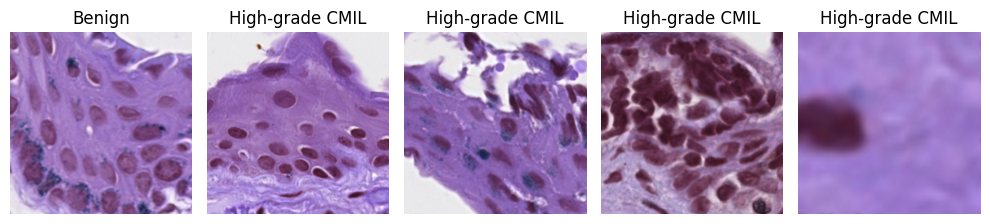

✅ Saved image paths and labels:
{'path': '/content/drive/My Drive/attention_patches_melan/patch_0_label_0.png', 'label': 0}
{'path': '/content/drive/My Drive/attention_patches_melan/patch_1_label_1.png', 'label': 1}
{'path': '/content/drive/My Drive/attention_patches_melan/patch_2_label_1.png', 'label': 1}
{'path': '/content/drive/My Drive/attention_patches_melan/patch_3_label_1.png', 'label': 1}
{'path': '/content/drive/My Drive/attention_patches_melan/patch_4_label_1.png', 'label': 1}


In [ ]:
# Add labels to each patch and match by their case, randomly split patients into training, validation, and testing sets

labels = pd.read_csv('/content/drive/My Drive/case_grade_match.csv') # Replace with the path to file

# Define a function to group patches by case number
def group_patches(patch_dir):
    case_patches = {}
    for filename in os.listdir(patch_dir):
        match = re.search(r"case_(\d+)", filename)  # Using regex for case number extraction
        if match:
            case_num = int(match.group(1))
            if case_num not in case_patches:
                case_patches[case_num] = []
            case_patches[case_num].append(os.path.join(patch_dir, filename))
    return case_patches

# Define a custom dataset class for loading PNG images
class PNGDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None):
        self.case_patches = case_patches
        self.labels_df = labels_df
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Label benign images 0, and high-grade CMIL images 1
        for case_num, patches in case_patches.items():
            label = labels_df.loc[labels_df['Case'] == case_num, 'Class'].values[0]
            label = 0 if label == 1 else 1
            for patch_path in patches:
                self.image_paths.append(patch_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        # Get patch images
        image = Image.open(image_path).convert('RGB')
        # Get the label information using the labels dataframe based on case number
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

# Resize all patch images to 256x256
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Possible data augmentation for training data
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

image_folder_path = '/content/drive/MyDrive/filtered_patches_SP2025_h&e_Apr27' # Replace with the path to filtered patches
patches = group_patches(image_folder_path)

# Get case numbers and their labels
case_nums = list(patches.keys())
dataset = labels.loc[[(int(x)-1) for x in case_nums]]

# Remove those that are equal to 2 (not classifying low-grade CMIL images currently)
noindex = ~dataset.Class.isin([0.0, 2.0])
X = dataset[noindex].Case
y = dataset[noindex].Class

# Ensure X and y have the same length before splitting
X = X.reset_index(drop=True)  # Reset index to avoid potential issues
y = y.reset_index(drop=True)  # Reset index to avoid potential issues

# Split the data into train, test, and validation sets
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)
train_X, val_X, y_train, y_val = train_test_split(train_X, y_train, test_size=0.2, stratify=y_train, random_state=40)

# Create the training, validation, and testing patches
train_patches = {case_num: patches[int(case_num)] for case_num in train_X} # Use train_X
val_patches = {case_num: patches[int(case_num)] for case_num in val_X} # Use val_X
test_patches = {case_num: patches[int(case_num)] for case_num in test_X} # Use test_X

def summarize_case_patches(split_name, split_dict, labels_df):
    print(f"\n📊 {split_name.upper()} SET SUMMARY:")
    print(f"Total cases: {len(split_dict)}")
    total_patches = benign_patches = high_grade_patches = unknown_cases = 0

    for case_num, patch_list in split_dict.items():
        num_patches = len(patch_list)
        total_patches += num_patches
        label_row = labels_df[labels_df['Case'] == int(case_num)]
        if label_row.empty:
            unknown_cases += 1
            continue
        original_label = label_row['Class'].values[0]
        label = 0 if original_label == 1 else 1
        if label == 0:
            benign_patches += num_patches
        else:
            high_grade_patches += num_patches
        print(f"  Case {case_num}: {num_patches} patches (Label: {'Benign' if label == 0 else 'High-grade'})")

    print(f"Total patches: {total_patches}")
    print(f"  Benign patches: {benign_patches}")
    print(f"  High-grade patches: {high_grade_patches}")
    if unknown_cases:
        print(f"  ⚠️ {unknown_cases} cases missing labels")

summarize_case_patches("train", train_patches, labels)
summarize_case_patches("val", val_patches, labels)
summarize_case_patches("test", test_patches, labels)


# Create PNGDataset instances for train, validation, and test
train_dataset = PNGDataset(train_patches, labels, transform=train_transform)
val_dataset = PNGDataset(val_patches, labels, transform=transform)
test_dataset = PNGDataset(test_patches, labels, transform=transform)

# Create DataLoaders using the PNGDataset instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count())  # Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # Shuffle validation data ### I DONT THINK THIS IS NEEDED
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # Do not shuffle test data

# Step 1: Get one batch from the train_loader
images, labels = next(iter(train_loader))

# Step 2: Select the first 5 images and labels
selected_images = images[:5]
selected_labels = labels[:5]

# Step 3: Save folder for images
save_dir = '/content/drive/My Drive/attention_patches_melan'
os.makedirs(save_dir, exist_ok=True)

# Step 4: Denormalization function (to convert back to displayable format)
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Step 5: Save images and visualize them
fig, axes = plt.subplots(figsize=(10, 4), ncols=5)

for i in range(5):
    # Denormalize the tensor for visualization/saving
    denorm_img = denormalize(selected_images[i].clone())

    # Save image tensor as PNG
    img_path = os.path.join(save_dir, f'patch_{i}_label_{selected_labels[i].item()}.png')
    save_image(denorm_img, img_path)

    # Display the image
    img_np = denorm_img.permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)
    axes[i].imshow(img_np)
    axes[i].set_title('Benign' if selected_labels[i] == 0 else 'High-grade CMIL')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Step 6: Optional - save metadata (image path and label) for future reference
saved_patch_info = [
    {"path": os.path.join(save_dir, f'patch_{i}_label_{selected_labels[i].item()}.png'),
     "label": selected_labels[i].item()}
    for i in range(5)
]

print("✅ Saved image paths and labels:")
for info in saved_patch_info:
    print(info)



📊 TRAIN SET SUMMARY:
Total cases: 38
  Case 98: 256 patches (Label: High-grade)
  Case 70: 44 patches (Label: High-grade)
  Case 42: 86 patches (Label: High-grade)
  Case 91: 15 patches (Label: High-grade)
  Case 55: 274 patches (Label: High-grade)
  Case 83: 963 patches (Label: High-grade)
  Case 84: 533 patches (Label: High-grade)
  Case 73: 584 patches (Label: High-grade)
  Case 48: 300 patches (Label: High-grade)
  Case 80: 224 patches (Label: High-grade)
  Case 88: 53 patches (Label: High-grade)
  Case 40: 190 patches (Label: High-grade)
  Case 53: 170 patches (Label: Benign)
  Case 78: 76 patches (Label: Benign)
  Case 96: 161 patches (Label: Benign)
  Case 12: 100 patches (Label: High-grade)
  Case 19: 147 patches (Label: High-grade)
  Case 100: 114 patches (Label: High-grade)
  Case 32: 143 patches (Label: High-grade)
  Case 46: 16 patches (Label: Benign)
  Case 50: 314 patches (Label: High-grade)
  Case 45: 34 patches (Label: Benign)
  Case 93: 78 patches (Label: Benign)
  Ca

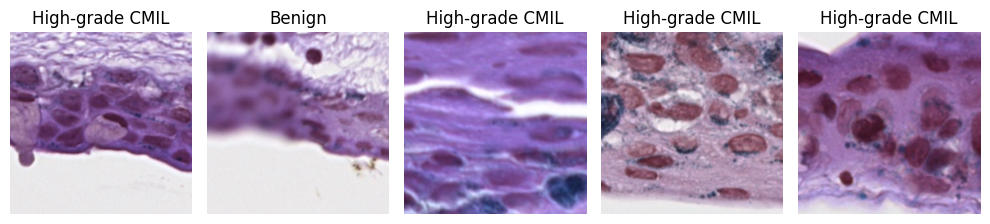

✅ Saved image paths and labels:
{'path': '/content/drive/My Drive/attention_patches_h&e/patch_0_label_1.png', 'label': 1}
{'path': '/content/drive/My Drive/attention_patches_h&e/patch_1_label_0.png', 'label': 0}
{'path': '/content/drive/My Drive/attention_patches_h&e/patch_2_label_1.png', 'label': 1}
{'path': '/content/drive/My Drive/attention_patches_h&e/patch_3_label_1.png', 'label': 1}
{'path': '/content/drive/My Drive/attention_patches_h&e/patch_4_label_1.png', 'label': 1}


In [ ]:
# Add labels to each patch and match by their case, randomly split patients into training, validation, and testing sets

labels = pd.read_csv('/content/drive/My Drive/case_grade_match.csv') # Replace with the path to file

# Define a function to group patches by case number
def group_patches(patch_dir):
    case_patches = {}
    for filename in os.listdir(patch_dir):
        match = re.search(r"case_(\d+)", filename)  # Using regex for case number extraction
        if match:
            case_num = int(match.group(1))
            if case_num not in case_patches:
                case_patches[case_num] = []
            case_patches[case_num].append(os.path.join(patch_dir, filename))
    return case_patches

# Define a custom dataset class for loading PNG images
class PNGDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None):
        self.case_patches = case_patches
        self.labels_df = labels_df
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Label benign images 0, and high-grade CMIL images 1
        for case_num, patches in case_patches.items():
            label = labels_df.loc[labels_df['Case'] == case_num, 'Class'].values[0]
            label = 0 if label == 1 else 1
            for patch_path in patches:
                self.image_paths.append(patch_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        # Get patch images
        image = Image.open(image_path).convert('RGB')
        # Get the label information using the labels dataframe based on case number
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

# Resize all patch images to 256x256
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Possible data augmentation for training data
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

image_folder_path = '/content/drive/MyDrive/filtered_patches_SP2025_h&e_Apr27_middle60' # Replace with the path to filtered patches
patches = group_patches(image_folder_path)

# Get case numbers and their labels
case_nums = list(patches.keys())
dataset = labels.loc[[(int(x)-1) for x in case_nums]]

# Remove those that are equal to 2 (not classifying low-grade CMIL images currently)
noindex = ~dataset.Class.isin([0.0, 2.0])
X = dataset[noindex].Case
y = dataset[noindex].Class

# Ensure X and y have the same length before splitting
X = X.reset_index(drop=True)  # Reset index to avoid potential issues
y = y.reset_index(drop=True)  # Reset index to avoid potential issues

# Split the data into train, test, and validation sets
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)
train_X, val_X, y_train, y_val = train_test_split(train_X, y_train, test_size=0.2, stratify=y_train, random_state=40)

# Create the training, validation, and testing patches
train_patches = {case_num: patches[int(case_num)] for case_num in train_X} # Use train_X
val_patches = {case_num: patches[int(case_num)] for case_num in val_X} # Use val_X
test_patches = {case_num: patches[int(case_num)] for case_num in test_X} # Use test_X

def summarize_case_patches(split_name, split_dict, labels_df):
    print(f"\n📊 {split_name.upper()} SET SUMMARY:")
    print(f"Total cases: {len(split_dict)}")
    total_patches = benign_patches = high_grade_patches = unknown_cases = 0

    for case_num, patch_list in split_dict.items():
        num_patches = len(patch_list)
        total_patches += num_patches
        label_row = labels_df[labels_df['Case'] == int(case_num)]
        if label_row.empty:
            unknown_cases += 1
            continue
        original_label = label_row['Class'].values[0]
        label = 0 if original_label == 1 else 1
        if label == 0:
            benign_patches += num_patches
        else:
            high_grade_patches += num_patches
        print(f"  Case {case_num}: {num_patches} patches (Label: {'Benign' if label == 0 else 'High-grade'})")

    print(f"Total patches: {total_patches}")
    print(f"  Benign patches: {benign_patches}")
    print(f"  High-grade patches: {high_grade_patches}")
    if unknown_cases:
        print(f"  ⚠️ {unknown_cases} cases missing labels")

summarize_case_patches("train", train_patches, labels)
summarize_case_patches("val", val_patches, labels)
summarize_case_patches("test", test_patches, labels)

# Create PNGDataset instances for train, validation, and test
train_dataset = PNGDataset(train_patches, labels, transform=train_transform)
val_dataset = PNGDataset(val_patches, labels, transform=transform)
test_dataset = PNGDataset(test_patches, labels, transform=transform)

# Create DataLoaders using the PNGDataset instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count())  # Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # Shuffle validation data ### I DONT THINK THIS IS NEEDED
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # Do not shuffle test data

# Step 1: Get one batch from the train_loader
images, labels = next(iter(train_loader))

# Step 2: Select the first 5 images and labels
selected_images = images[:5]
selected_labels = labels[:5]

# Step 3: Save folder for images
save_dir = '/content/drive/My Drive/attention_patches_h&e'
os.makedirs(save_dir, exist_ok=True)

# Step 4: Denormalization function (to convert back to displayable format)
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Step 5: Save images and visualize them
fig, axes = plt.subplots(figsize=(10, 4), ncols=5)

for i in range(5):
    # Denormalize the tensor for visualization/saving
    denorm_img = denormalize(selected_images[i].clone())

    # Save image tensor as PNG
    img_path = os.path.join(save_dir, f'patch_{i}_label_{selected_labels[i].item()}.png')
    save_image(denorm_img, img_path)

    # Display the image
    img_np = denorm_img.permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)
    axes[i].imshow(img_np)
    axes[i].set_title('Benign' if selected_labels[i] == 0 else 'High-grade CMIL')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Step 6: Optional - save metadata (image path and label) for future reference
saved_patch_info = [
    {"path": os.path.join(save_dir, f'patch_{i}_label_{selected_labels[i].item()}.png'),
     "label": selected_labels[i].item()}
    for i in range(5)
]

print("✅ Saved image paths and labels:")
for info in saved_patch_info:
    print(info)
